### Load basic required libraries

In [1]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re

from PIL import Image
import base64

import seaborn as sns

### Load VGG feature analysis libraries and scripts

In [3]:
# import torch
# import torchvision.models as models
# import torch.nn as nn
# import torchvision.transforms as transforms
# import torch.nn.functional as F
# from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from glob import glob
import os

# import embedding as emb
# reload(emb)
# from embedding import *

## extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract (mini verison of) adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png_mini' --layer_ind=6 --cohort='adult' --spatial_avg=True`

In [14]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def get_class_means_not_normalized(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    
def load_features_chinadraw(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    F = np.load('/home/bria/kiddraw/analysis/chinadraw/python/features/FEATURES_{}_{}.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('/home/bria/kiddraw/analysis/chinadraw/python/features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']  
    current = os.getcwd()
    F = np.load(os.path.join(current, 'FEATURES_{}_{}.npy'.format(layers[layer_num],cohort)) )
    M = pd.read_csv(os.path.join(current,'METADATA_{}.csv'.format(cohort)) ) 
    M = M[['label','age','session']]
    return F, M

def load_adult_features(layer_ind):
    ## load in adult features
    AF, AM = load_features('adult',layer_ind)
    AM = AM.reset_index(drop=True)
    return AF, AM

## apply clustering to organize RDM so that we can see some block diagonal structure
def flatten(x):
    return [item for sublist in x for item in sublist]

### Extract adult drawing features

In [16]:
layer_ind=5
AF, AM = load_adult_features(layer_ind)

In [17]:
## Every row is an image, every column is a feature. 

### Get sorting indexes for ploting RMDS

In [18]:
## Load layer 6 features for adults and use these to sort
AF_S, AM_S = load_adult_features(layer_ind)

## retrieve alpha sorted labels from meta
_labels = np.unique(AM_S.label.values)
means = get_class_means(AF_S, AM_S.label.values)
af = AffinityPropagation(damping=.5).fit(means)
labels = af.labels_
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

ordered_objs = []
print('Clusters')
for k in range(n_clusters_):
    class_members = labels == k
    print _labels[class_members]
    ordered_objs.append(list(_labels[class_members]))
    
ordered_objs = np.array(flatten(ordered_objs))

# define standard order to be used for RDM's across layers
standard_order = ordered_objs

## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

Clusters
['airplane' 'boat' 'carrot' 'ice cream' 'mushroom' 'spider']
['apple']
['bed' 'chair' 'couch' 'fork' 'hat' 'piano' 'table']
['bus' 'car' 'train']
['cookie']
['banana' 'bear' 'bicycle' 'bird' 'cat' 'dog' 'duck' 'flower' 'frog'
 'horse' 'keys' 'rabbit' 'shark' 'sheep']
['cup' 'door' 'fish' 'foot' 'phone' 'shoe']


In [19]:
n_clusters_

7

### Representational Similarity Analyses

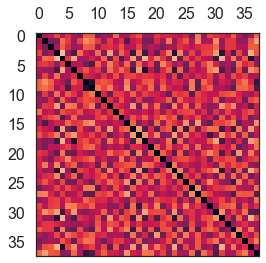

In [21]:
means = get_class_means(AF, AM.label.values)
CORRMAT = np.corrcoef(means)
np.shape(CORRMAT)
plt.matshow(1-CORRMAT, vmin=0, vmax=2)

In [22]:
if not os.path.exists('./plots'):
    os.makedirs('./plots')

    ## Representational dissimilarity matrix
def get_and_plot_RDM(M,F,cohort,sort_inds, layer_ind):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:] ## a way to sort the cateogries
    sns.set_style('white')
    CORRMAT = np.corrcoef(ordered_means)

    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(1-CORRMAT, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    RDM = CORRMAT
    plt.gcf().subplots_adjust(left=0.5) 
    plt.savefig('./plots/RDM_{}_Layer_{}.pdf'.format(cohort, layer_ind), bbox_inches="tight")
    return RDM

def showRDM(RDM,ordered_objs):
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(RDM, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  

def get_RDM(M,F,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]    
    RDM = np.corrcoef(ordered_means)
    return RDM

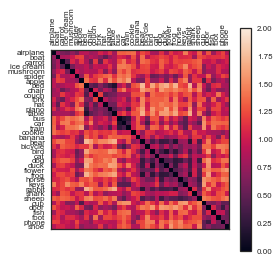

In [23]:
## get and plot sorted adult RDM
ARDM = get_and_plot_RDM(AM, AF,'adult',sort_inds,layer_ind)